# Using classical splittings for non-autonomous differential equations

[Back to evolve quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, abs, real, pi, diag, imag
from torch.linalg import matrix_exp


from IPython.display import display, Markdown

# Time-dependent potential


The linear time-dependent Schrödinger equation in 1D with with time-dependent Hamiltonian can be written in the following form

$$ i \partial_t \psi(x,t) = \mathrm{H}(t) \psi(x,t), \qquad x \in [-L,L] $$

We consider explicitly time-dependent Hamiltonian operators $\mathrm{H}(t)$ of the form

$$ \mathrm{H} = -\partial_x^2 + V(x,t) $$

e.g. 

$$ V(x,t) = V_0(x) + c_1 e^{-\frac{(x-(x_0+t)).^2}{2\sigma^2}}\sin(8 \pi (x-t)) - c_2 \sin(5 \pi t)x $$

for $x_0 = -2$, $c_1 = c_2 = 10^2$, $\sigma = 0.5$.

This non-autonomous equation can be made autonomous by extending the state to 

$$\Psi(x, t) = \begin{pmatrix} \psi(x,t) \\ \tau\end{pmatrix}, \quad \text{s.t.} \quad \partial_t \psi(x,t) = -i \mathrm{H}(\tau) \psi(x,t) \quad \text{and} \quad \partial_t \tau = 1 $$

Thus,

$$\partial_t \Psi(x, t) = \begin{pmatrix} i \partial_x^2 \psi(x,t) - i V(\tau) \psi(x,t) \\ 1\end{pmatrix}, \quad \text{and} \quad \Psi(x, 0) = \begin{pmatrix} \psi(x,0) \\ \tau(0)\end{pmatrix} $$

We break the flow of $\Psi$ into two subflows:

$$ \Phi^{\partial_x^2}_h \begin{pmatrix} \psi(x,t) \\ \tau\end{pmatrix} = \begin{pmatrix} \exp(i h \partial_x^2) \psi(x,t) \\ \tau + h \end{pmatrix} \quad \text{which is the flow of} \quad \partial_t \Psi(x, t) = \begin{pmatrix} i \partial_x^2 \psi(x,t) \\ 1\end{pmatrix},$$

and 

$$ \Phi^{V}_h \begin{pmatrix} \psi(x,t) \\ \tau\end{pmatrix} = \begin{pmatrix} \exp(-i h V(\tau)) \psi(x,t) \\ \tau \end{pmatrix} \quad \text{which is the flow of} \quad \partial_t \Psi(x, t) = \begin{pmatrix} -i V \psi(x,t) \\ 0\end{pmatrix}.$$

Thus, we can solve this non-autonomous differential equation by using a classical splitting by introducing an internal time $\tau$ that advances with each action of $-\partial_x^2$. 

Specifically, we compute

$$u_{n+1} = \exp\left(- i h \beta_K V(\tau_K) \right) \exp\left(i h \alpha_K\, \mathbf{D}_2\right) \ldots \exp\left(- i h \beta_2 V(\tau_2) \right) \exp\left(i h \alpha_2\, \mathbf{D}_2\right) \exp\left(- i h \beta_1 V(\tau_1) \right) \exp\left(i h \alpha_1\, \mathbf{D}_2\right)u_n $$

where 

$$ \tau_k = \tau_{k-1} + h\alpha_k, \qquad \tau_0 = t_n $$

#### Initial conditions and time-independent potential

In [22]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)

V = x**4 - 10*x**2

#### Time dependent potential

In [36]:
sigma = 0.5
c1 = 5.
c2 = 5.
x0 = -2

Vt = lambda t : V + c1 * exp(-(x-(x0+t))**2/(2*sigma)) * sin(2*pi*(x-t)) - c2 * sin(5*pi*t) * x

trange = [0, 1]
timegrid = es.timegrid(trange, ndt=200)

#### Define subflows

Since we are dealing with a time-dependent potential, the most straight-forward way of working with the non-autonomous case is to make `eVu` sample `Vt` at `t`. Note that `split.stepper` will internally use the appropriate time $t=\tau_k$, not $t=t_n$. 

In [37]:
eLu = lambda t, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, h, c, u: exp(-1j*c*h*Vt(t))*u    

#### Creating steppers

In [38]:
trotteralpha, trotterbeta = split.consistent([],[])
trotterstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, trotteralpha, trotterbeta)

strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
blanesmoanstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, blanesmoanalpha, blanesmoanbeta)

#### Observables

In [39]:
observables = {'energy': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + Vt(t)*psi, u, xr), 
'position': lambda u, t: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u, t: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u, t: ex.observable(lambda psi: Vt(t)*psi, u, xr)}

#### Computing solutions

In [40]:
steppers = {'Trotter': trotterstep, 'Strang': strangstep, 'Blanes-Moan': blanesmoanstep}
uT = {}
uintermediate = {}
obsvalues = {}
for methodname in steppers:
    uT[methodname], obsvalues[methodname], uintermediate[methodname] = es.solvediffeq(u, timegrid, steppers[methodname], observables, storeintermediate=True)    

In [57]:
lines = lambda frame: [((x, (Vt(timegrid[frame]))/100), {'color':mcolors.CSS4_COLORS['steelblue']}, 'V'), 
                       ((x, imag(uintermediate['Strang'][frame])), {'color':mcolors.CSS4_COLORS['gold']}, 'Im(u)'),
                       ((x, real(uintermediate['Strang'][frame])), {'color':mcolors.CSS4_COLORS['yellowgreen']}, 'Re(u)'),
                       ((x, abs(uintermediate['Strang'][frame])), {'color':mcolors.CSS4_COLORS['darkorange']}, '|u|')]

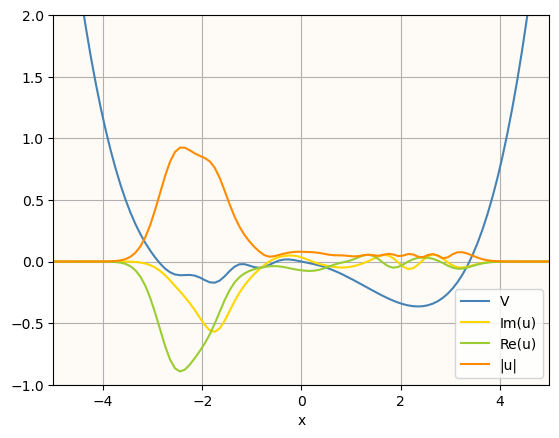

In [58]:
fig, ax = plt.subplots()
ex.plot(ax, linespecs=lines(100), xlim=[-5,5], ylim=[-1,2], xlabel='x')
plt.show()

In [60]:
drawframe = lambda ax, frame: ex.plot(ax, linespecs=lines(frame), xlim=[-5,5], ylim=[-1,2])
outputgif = 'nonautonomous_borderless.gif'
es.animate(drawframe, len(uintermediate['Strang']), outputgif, speedfactor=1, border=False)
display(Markdown(f'![gif]({outputgif})'))

![gif](nonautonomous_borderless.gif)

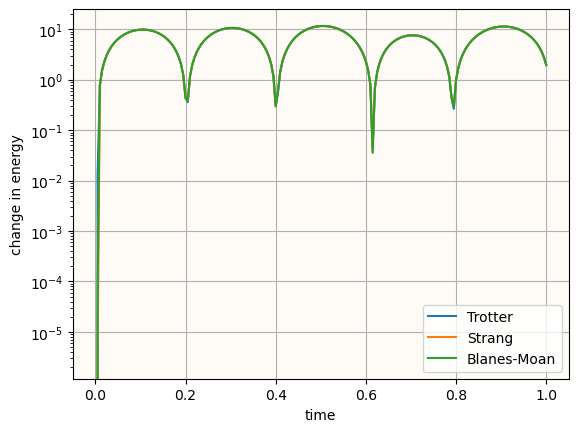

In [64]:
E0 = obsvalues['Trotter']['energy'][0][0]
lines = [((timegrid, abs(obsvalues[methodname]['energy']-E0)), {}, methodname) for methodname in obsvalues]

fig, ax = plt.subplots()
ex.semilogy(ax, linespecs=lines, xlabel='time', ylabel='change in energy', separatelines=True)
plt.show()

The energy is no longer conserved! That's because we have a time-dependent Hamiltonian now.

## Reference solution

This time around, the brute force solution is very expensive. Instead we use Strang splitting with very small time-step as the reference.

### Warning: will take 1-5 minutes

In [62]:
timegrid_ref = es.timegrid(trange, ndt=2**12)
u_ref, _, _ = es.solvediffeq(u, timegrid_ref, blanesmoanstep)

order of the Trotter splitting is 1.0
order of the Strang splitting is 2.0
order of the Blanes-Moan splitting is 4.0


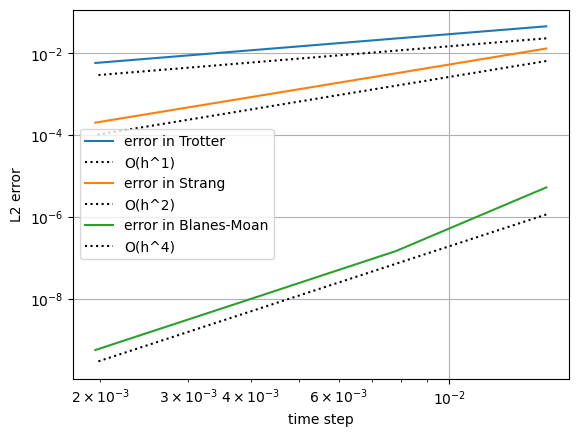

In [65]:
normfn = lambda u0, u1: ex.l2norm(u0-u1, xr)
steppers={'Trotter': trotterstep, 'Strang': strangstep, 'Blanes-Moan': blanesmoanstep}
ord, _ = es.order(u, u_ref, normfn, trange, ndtlist=2**np.arange(6,10), steppers=steppers)

for stepper in steppers:
    print(f'order of the {stepper} splitting is {ord[stepper]}')